<a href="https://colab.research.google.com/github/TsarIM/LipNet/blob/main/LipNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import cv2
import gdown

In [2]:
dataset_link = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(dataset_link, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=9cdff8c6-d2fe-4c72-98aa-e52106ec2003
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 119MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [3]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    l=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for _ in range(l):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:240,110:210,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames-mean), tf.float32)/std

In [4]:
vocab= ['','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' ']

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

0 14000 sil<br>
14000 20250 bin<br>
20250 27250 blue<br>
27250 32500 at<br>
32500 37750 e<br>
37750 48750 eight<br>
48750 62000 soon<br>
62000 74500 sil<br>

<br>above is the example of an alignment file


In [6]:
def load_alignments(path):
    with open(path,'r') as file:
        lines = file.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    tokens = tf.constant(tokens)
    if tf.size(tokens)>0:
        return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]
    else:
        return tf.constant([], dtype=tf.int32)

In [7]:
tensor=num_to_char(load_alignments('data/alignments/s1/swai1s.align'))
print(tensor)
joined_string = tf.strings.reduce_join(tensor).numpy().decode('utf-8')
print(joined_string)

tf.Tensor(
[b's' b'e' b't' b' ' b'w' b'h' b'i' b't' b'e' b' ' b'a' b't' b' ' b'i'
 b' ' b'o' b'n' b'e' b' ' b's' b'o' b'o' b'n'], shape=(23,), dtype=string)
set white at i one soon


In [8]:
def load_data(path):

    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]

    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

def apply_load_data(path):
    data = tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return data

<tf.Tensor: shape=(), dtype=string, numpy=b'set white with v six now'>

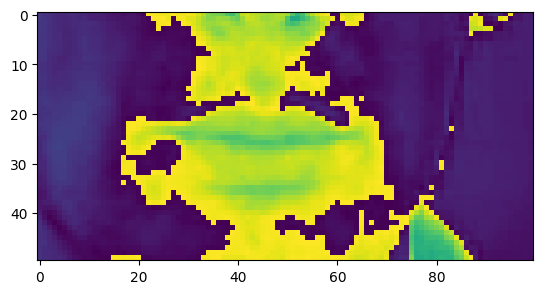

In [9]:
test_path='data/alignments/s1/swwv6n.align'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
frames, alignments = load_data(tf.convert_to_tensor(test_path))
plt.imshow(frames[21])
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

In [10]:
dataset = tf.data.Dataset.list_files('./data/s1/*.mpg')
dataset = dataset.shuffle(500, reshuffle_each_iteration=False)
dataset = dataset.map(apply_load_data)
dataset = dataset.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
dataset = dataset.prefetch(tf.data.AUTOTUNE)
print(len(dataset))

500


In [11]:
train = dataset.take(450)
test = dataset.skip(50)
print(len(train),len(test))

450 450


In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [13]:
model=keras.Sequential([

    layers.Conv3D(128,3,input_shape=(75,50,100,1),padding='same',activation='relu'),
    layers.MaxPooling3D((1,2,2)),

    layers.Conv3D(256,3,input_shape=(75,50,100,1),padding='same',activation='relu'),
    layers.MaxPooling3D((1,2,2)),

    layers.Conv3D(75,3,input_shape=(75,50,100,1),padding='same',activation='relu'),
    layers.MaxPooling3D((1,2,2)),

    layers.TimeDistributed(layers.Flatten()),

    layers.Bidirectional(layers.GRU(128,kernel_initializer='orthogonal',return_sequences=True)),
    layers.Dropout(.5),

    layers.Bidirectional(layers.GRU(128,kernel_initializer='orthogonal',return_sequences=True)),
    layers.Dropout(.5),

    layers.Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')

])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 50, 100, 128   3584      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 25, 50, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 25, 50, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 75, 12, 25, 256)   0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 12, 25, 75)    518475    
                                                        

In [15]:
#you can refer to  https://keras.io/examples/audio/ctc_asr/   for this implementation of CTC loss, this loss was used in the lipnet paper
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [16]:
def scheduler(epoch, lr):
    if epoch<30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [18]:
model_checkpoint= ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss',save_weights_only=True)

In [19]:
lr_scheduler= LearningRateScheduler(scheduler)

In [20]:
model.fit(train, validation_data=test, epochs=100, callbacks=[model_checkpoint, lr_scheduler])

Epoch 1/100
450/450 [==============================] - 712s 2s/step - loss: 83.3071 - val_loss: 70.3783 - lr: 1.0000e-04
Epoch 2/100
450/450 [==============================] - 681s 2s/step - loss: 72.1769 - val_loss: 65.6354 - lr: 1.0000e-04
Epoch 3/100
450/450 [==============================] - 678s 2s/step - loss: 68.4051 - val_loss: 63.3957 - lr: 1.0000e-04
Epoch 4/100
450/450 [==============================] - ETA: 0s - loss: 65.7679

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-8-05d94c3ac569>", line 9, in load_data
    frames = load_video(video_path)

  File "<ipython-input-3-8f98cccd6b12>", line 8, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[CTCLoss/CTCLoss/_74]]
  (1) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-8-05d94c3ac569>", line 9, in load_data
    frames = load_video(video_path)

  File "<ipython-input-3-8f98cccd6b12>", line 8, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_1498485]